# Store sales
 
Задача по прогнозированию объема продаж в магазине на основе данных Corporación Favorita, крупного эквадорского розничного продавца продуктов питания.

Необходимо построить модель, которая более точно прогнозирует объем продаж тысяч товаров, продаваемых в различных магазинах Favorita. Исходный набор данных содержит даты, информацию о магазинах и товарах, рекламных акциях и распродажах.

## Описание исходных данных

### train.csv    
**store_nbr** - номер магазина  
**family** - категория товара  
**sales** - общий объем продаж данной категории товара в указанном магазине в определенную дату. Целевая переменная.  
**onpromotion** -  общее количество товаров в данной категории, которые продвигались в указанном магазине в указанную дату. 

### test.csv  
Тестовый набор данных. Содержит те же значения, что и train.csv, кроме целевой переменной **sales**, которую нужно предсказать

### stores.csv  
Метаданные по магазинам  
**store_nbr** - номер магазина  
**city** - город, в котором расположен магазин  
**state** - штат  
**type** - тип магазина  
**cluster** - номер кластера, в котором сгруппированы похожие магазины. 

### oil.csv  
Ежедневные цены на нефть в течение обоих периодов, указанных в тренировочных и тестовых данных. Эквадор - страна, экономика которой сильно зависит от цен на нефть.

### holidays_events.csv  
Праздники и события  
ПРИМЕЧАНИЕ. Обратите особое внимание на **Transfer**. Перенесенный праздник официально приходится на этот календарный день, но был перенесен правительством на другую дату. Перенесенный день больше похож на обычный день, чем на праздник. Чтобы найти день, когда он действительно отмечался, найдите соответствующую строку, где тип — Перенос. Например, праздник Независимости Гуаякиля был перенесен с 09.10.2012 на 12.10.2012, что означает, что он отмечался 12.10.2012.  
Дни типа **Bridge** — это дополнительные дни, которые добавляются к празднику (например, чтобы продлить перерыв на длинные выходные).   
Тип **Work_day**, представляет собой день, обычно не запланированный для работы (например, суббота), предназначенный для окупаемости Bridge.  
**Additional** — это дни, добавленные к обычному календарному празднику, например, как это обычно бывает перед Рождеством (сочельник становится праздником).

### Дополнительные сведения  
Заработная плата в государственном секторе выплачивается каждые две недели – 15-го и в последний день месяца. Это может повлиять на продажи в супермаркетах.
Землетрясение магнитудой 7,8 произошло в Эквадоре 16 апреля 2016 года. Люди сплотились, чтобы оказать помощь, жертвуя воду и другие продукты первой необходимости, что сильно повлияло на продажи в супермаркетах в течение нескольких недель после землетрясения.

## Решение

### Импорты

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns
from datetime import datetime

# Cleaning
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Spliting
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
# Feature Engigeering
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [4]:
# Models
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from concurrent.futures import ThreadPoolExecutor

In [5]:
# Cross-validation
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold

In [6]:
# warnings off
import warnings
warnings.filterwarnings("ignore")

### Загрузка датасетов

In [7]:
train = pd.read_csv('data/train.csv')
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [8]:
train.shape

(3000888, 6)

In [9]:
test = pd.read_csv('data/test.csv')
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [10]:
test.shape

(28512, 5)

In [11]:
stores = pd.read_csv('data/stores.csv')
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [12]:
oil = pd.read_csv('data/oil.csv')
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [13]:
holidays = pd.read_csv('data/holidays_events.csv')
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


### Объединение датасетов

In [14]:
def merge_df(df):
    df_copy = df.copy()
    df_merged = pd.merge(df_copy, oil, how='left', on='date')
    df_merged = pd.merge(df_merged, stores, how='left', on='store_nbr')
    df_merged = pd.merge(df_merged, holidays, how='left', on='date')
    
    return df_merged

In [15]:
train_merge = merge_df(train)
test_merge = merge_df(test)

In [16]:
train_merge.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False


In [17]:
test_merge.head()

,id,date,store_nbr,family,onpromotion,dcoilwtico,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred
0,3000888,2017-08-16,1,AUTOMOTIVE,0,46.8,Quito,Pichincha,D,13,NaN,NaN,NaN,NaN,NaN
1,3000889,2017-08-16,1,BABY CARE,0,46.8,Quito,Pichincha,D,13,NaN,NaN,NaN,NaN,NaN
2,3000890,2017-08-16,1,BEAUTY,2,46.8,Quito,Pichincha,D,13,NaN,NaN,NaN,NaN,NaN
3,3000891,2017-08-16,1,BEVERAGES,20,46.8,Quito,Pichincha,D,13,NaN,NaN,NaN,NaN,NaN
4,3000892,2017-08-16,1,BOOKS,0,46.8,Quito,Pichincha,D,13,NaN,NaN,NaN,NaN,NaN


## Предобработка

In [18]:
train_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 16 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
 6   dcoilwtico   float64
 7   city         object 
 8   state        object 
 9   type_x       object 
 10  cluster      int64  
 11  type_y       object 
 12  locale       object 
 13  locale_name  object 
 14  description  object 
 15  transferred  object 
dtypes: float64(2), int64(4), object(10)
memory usage: 372.8+ MB


Преобразуем даты в нужный формат

In [19]:
def date_format(df):
    df['date'] = pd.to_datetime(df['date'])
    return df

In [20]:
train_merge = date_format(train_merge)
test_merge = date_format(test_merge)

In [21]:
train_merge.isna().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
dcoilwtico      955152
city                 0
state                0
type_x               0
cluster              0
type_y         2551824
locale         2551824
locale_name    2551824
description    2551824
transferred    2551824
dtype: int64

Заполняем пропуски в ценах на нефть с помощью интерполяции:

In [22]:
def oil_intetpolate(df):
    df['dcoilwtico'] = df['dcoilwtico'].interpolate()
    return df

In [23]:
train_merge = oil_intetpolate(train_merge)
test_merge = oil_intetpolate(test_merge)

In [24]:
train_merge.isna().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
dcoilwtico        1782
city                 0
state                0
type_x               0
cluster              0
type_y         2551824
locale         2551824
locale_name    2551824
description    2551824
transferred    2551824
dtype: int64

Проверяем, в какие даты у нас остались пропуски в ценах на нефть:

In [25]:
train_merge[train_merge['dcoilwtico'].isna()]['date'].value_counts()

date
2013-01-01    1782
Name: count, dtype: int64

Не прошла интерполяцию только самая первая дата в графике - 1 января 2013 года. Заполним ее вручную.

In [26]:
def oil_fill(df):
    df['dcoilwtico'] = df['dcoilwtico'].fillna(93)
    return df

In [27]:
train_merge = oil_fill(train_merge)
test_merge = oil_fill(test_merge)

In [28]:
train_merge.isna().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
dcoilwtico           0
city                 0
state                0
type_x               0
cluster              0
type_y         2551824
locale         2551824
locale_name    2551824
description    2551824
transferred    2551824
dtype: int64

type_x - это тип магазина.  
type_y - это тип праздника.  
Переименуем эти столбцы, чтобы не путаться

In [29]:
def rename_columns(df):
    df_copy = df.copy()
    df_copy['type_shop'] = df_copy['type_x']
    df_copy['type_hol'] = df_copy['type_y']
    df_copy = df_copy.drop(columns=['type_x', 'type_y'], axis=1)
    return df_copy

In [30]:
train_merge = rename_columns(train_merge)
test_merge = rename_columns(test_merge)

In [31]:
train_merge.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,cluster,locale,locale_name,description,transferred,type_shop,type_hol
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.0,Quito,Pichincha,13,National,Ecuador,Primer dia del ano,False,D,Holiday
1,1,2013-01-01,1,BABY CARE,0.0,0,93.0,Quito,Pichincha,13,National,Ecuador,Primer dia del ano,False,D,Holiday
2,2,2013-01-01,1,BEAUTY,0.0,0,93.0,Quito,Pichincha,13,National,Ecuador,Primer dia del ano,False,D,Holiday
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.0,Quito,Pichincha,13,National,Ecuador,Primer dia del ano,False,D,Holiday
4,4,2013-01-01,1,BOOKS,0.0,0,93.0,Quito,Pichincha,13,National,Ecuador,Primer dia del ano,False,D,Holiday


Заполняем пропуски в строковых колонках праздников дефисами

In [32]:
def no_holiday(df):
    lst = ['type_hol', 'locale', 'locale_name', 'description', 'transferred']
    for column in lst:
        df[column] = df[column].fillna('-')
    return df

In [33]:
train_merge = no_holiday(train_merge)
test_merge = no_holiday(test_merge)

In [34]:
train_merge.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dcoilwtico     0
city           0
state          0
cluster        0
locale         0
locale_name    0
description    0
transferred    0
type_shop      0
type_hol       0
dtype: int64

In [35]:
test_merge.isna().sum()

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dcoilwtico     0
city           0
state          0
cluster        0
locale         0
locale_name    0
description    0
transferred    0
type_shop      0
type_hol       0
dtype: int64

Теперь мы убедились в том, что пропуски заполнены.

## Анализ данных

In [36]:
# Анализ числовых значений
train_merge.describe().round(3)

,id,date,store_nbr,sales,onpromotion,dcoilwtico,cluster
count,3054348.000,3054348,3054348.000,3054348.000,3054348.000,3054348.000,3054348.000
mean,1504276.775,2015-04-26 12:11:45.717619200,27.500,359.021,2.617,67.825,8.481
min,0.000,2013-01-01 00:00:00,1.000,0.000,0.000,26.190,1.000
25%,754676.750,2014-03-01 00:00:00,14.000,0.000,0.000,46.320,4.000
50%,1507571.500,2015-04-28 12:00:00,27.500,11.000,0.000,53.297,8.500
75%,2255120.250,2016-06-22 00:00:00,41.000,196.011,0.000,95.768,13.000
max,3000887.000,2017-08-15 00:00:00,54.000,124717.000,741.000,110.620,17.000
std,866261.012,NaN,15.586,1107.286,12.255,25.681,4.650


Числовые значения привязаны к временному ряду. Общая таблица (выше) в этом плане мало что может нам сказать. Интересный параметр - cluster. Проверим показатели продаж по кластерам

In [37]:
clusters = train_merge.groupby(['cluster']).agg({
    'sales': 'sum',
    'onpromotion': 'sum'
})

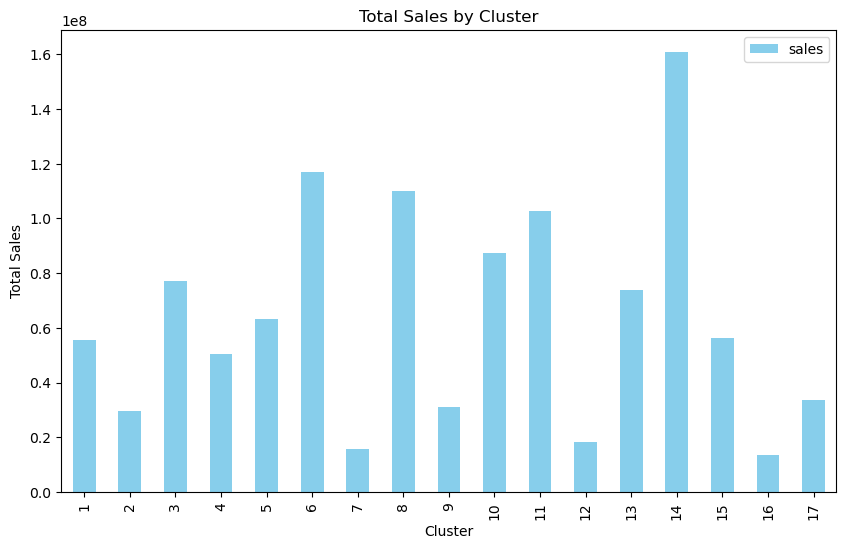

In [38]:
# Строим столбчатую диаграмму продаж по кластерам
clusters.plot(kind='bar', y='sales', color = 'skyblue', figsize=(10, 6))

plt.title('Total Sales by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Sales')

plt.show()

Продажи по кластерам сильно разнятся. Это значит, что параметр cluster имеет очень важное значение.

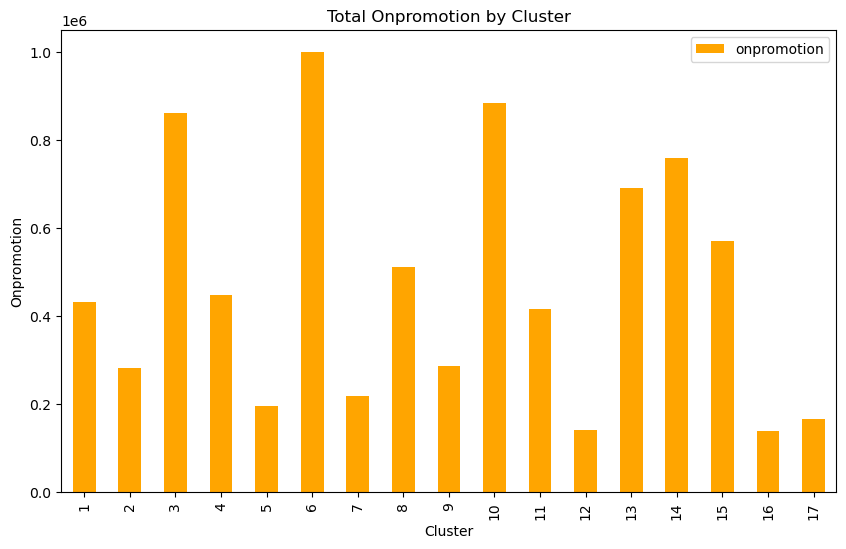

In [39]:
# Строим столбчатую диаграмму количества продвигаемых товаров по кластерам
clusters.plot(kind='bar', y='onpromotion', color='orange', figsize=(10, 6))

plt.title('Total Onpromotion by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Onpromotion')

plt.show()

Параметр onpromotion значительно разница в зависимости от кластера. Вероятно он коррелирует с параметром sales по кластерам. Проверим корреляцию числовых признаков в датасете.

In [40]:
# Функция, возвращающая датасет только с числовыми признаками
def num_col(df):
    num_col = []
    for column in df.columns:
        if (df[column].dtype == 'int64') or (df[column].dtype == 'float64'):
            num_col.append(column)
    return df[num_col]

In [41]:
train_merge_num = num_col(train_merge)

In [42]:
corr_matrix = train_merge_num.corr()
corr_matrix

,id,store_nbr,sales,onpromotion,dcoilwtico,cluster
id,1.000000,0.000301,0.086102,0.206032,-0.839132,-0.000044
store_nbr,0.000301,1.000000,0.041273,0.007744,-0.000203,-0.059284
sales,0.086102,0.041273,1.000000,0.428241,-0.075624,0.038537
onpromotion,0.206032,0.007744,0.428241,1.000000,-0.154592,0.005702
dcoilwtico,-0.839132,-0.000203,-0.075624,-0.154592,1.000000,0.000029
cluster,-0.000044,-0.059284,0.038537,0.005702,0.000029,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

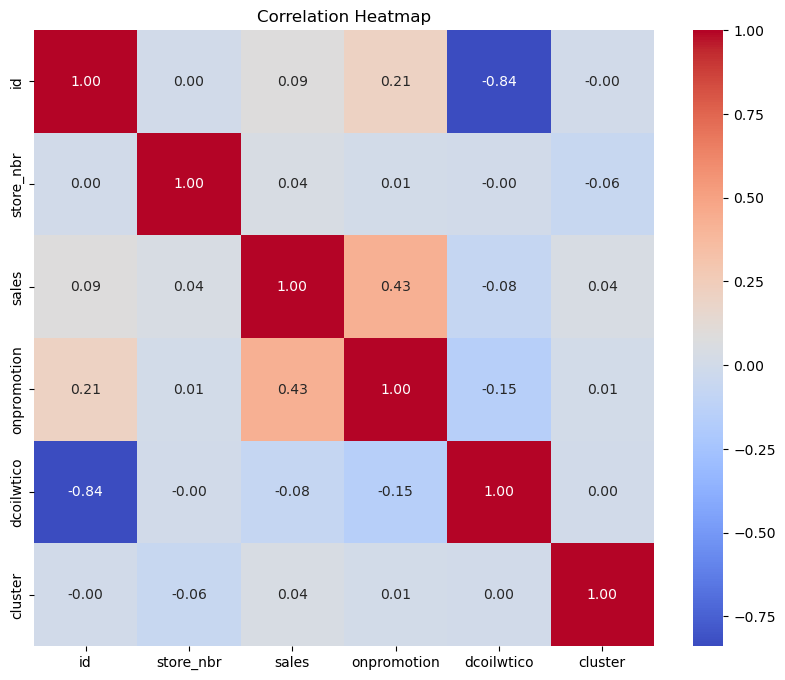

In [43]:
# Создание тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')

Тепловая карта корреляции числовых признаков нам показывает, что:  
1) Цены на нефть коррелируют с колонкой id. Вероятно, это случайное совпадение. Но в любом случае корреляция id не имеет практического смысла. В модели признак id учитываться не будет.  
2) Несущественная корреляция между признаками onpromotion и sales, что в целом закономерно. Коэффициет 0,43 - небольшой и не будет критически влиять на модель.  
3) Других больших коэффициентов на карте нет - это значит, что числовые данные в целом сбалансированы. Между признаками отсутствуют линейные зависимости. 

### Цены на нефть

In [44]:
%%script false
# Установка стиля графика
sns.set(style="whitegrid")

# Создание графика
plt.figure(figsize=(12, 6))  # Устанавливаем размер графика

# Используем Seaborn для построения графика
sns.lineplot(x='date', y='dcoilwtico', data=train_merge)

# Настройка подписей осей и заголовка
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.title('Oil Prices')

# Поворот меток оси x, если даты слишком плотно идут
plt.xticks(rotation=45)

# Отображение графика
plt.show()

Couldn't find program: 'false'


<img src='data/oil_chart.png' />

Визуально по графику можно выделить 4 зоны:  
**Зона 0** - горизонтальный коридор цен с 2013 по середну 2014 года в значениях от 85 и выше. В этот период рынок относительно спокоен.  
**Зона 1** - нисходящий тренд во второй половине 2014 года. Диапазон 65-85.  
**Зона 2** - горизонтальный корридор цен в диапазоне 40-65, где рынок также относительно спокоен.  
**Зона 3** - просадка цены на нефть ниже 40.  

Валотильность цены на нефть на некоторых отрезках довольно высока. При сильном влиянии на продуктовый рынок, валотильность должна являться вспомогательным фактором, определяющим объем продаж в магазинах.  

**Выводы:**  
1. Создадим фичу ценовых зон *oil_price_zone* с указанными значениями;  
2. Создадим фичи *delta_oil_week*, *delta_oil_month* и *delta_oil_3mon*, которые будут обозначать разницу в ценах на нефть между ценой на нефть в указанную дату и ценой на нефть за неделю, месяц и 3 месяца. 

In [45]:
# Функция создания фич по нефти
def oil_features(df):
    df_copy = df.copy()
    
    # колонка id содержит часть неуникальных значений по непонятной причине, поэтому для уверенности 
    # создадим свою колонку index, в которой все значения будут уникальными:
    df_copy['index'] = [i  for i in range(len(df))]
    
    df_copy['oil_zone'] = df_copy['dcoilwtico'].apply(lambda x: 0 if x > 85 else(1 if x > 65 else(2 if x > 40 else 3)))
    temp_df = df_copy.set_index('index')
    
    temp_df['oil_price_week_ago'] = temp_df['dcoilwtico'].shift(7)
    temp_df['delta_oil_week'] = temp_df['dcoilwtico'] - temp_df['oil_price_week_ago']
    
    temp_df['oil_price_month_ago'] = temp_df['dcoilwtico'].shift(30)
    temp_df['delta_oil_month'] = temp_df['dcoilwtico'] - temp_df['oil_price_month_ago']
    
    temp_df['oil_price_3month_ago'] = temp_df['dcoilwtico'].shift(90)
    temp_df['delta_oil_3mon'] = temp_df['dcoilwtico'] - temp_df['oil_price_3month_ago']
    
    df_copy_merged = pd.merge(df_copy, temp_df[['delta_oil_week', 'delta_oil_month', \
                                                'delta_oil_3mon']], how='left', on='index')
    
    df_copy_merged.drop(columns=['index'], axis=1, inplace=True)
    
    return df_copy_merged

In [46]:
train_merge = oil_features(train_merge)
test_merge = oil_features(test_merge)

In [47]:
train_merge.isna().sum()

id                  0
date                0
store_nbr           0
family              0
sales               0
onpromotion         0
dcoilwtico          0
city                0
state               0
cluster             0
locale              0
locale_name         0
description         0
transferred         0
type_shop           0
type_hol            0
oil_zone            0
delta_oil_week      7
delta_oil_month    30
delta_oil_3mon     90
dtype: int64

Пропуски в "дельтах" образовались в начале, поскольку там нет данных для рассчета. Заполним их нулями

In [48]:
def fillna_delta_oil(df):
    df['delta_oil_week'] = df['delta_oil_week'].fillna(0)
    df['delta_oil_month'] = df['delta_oil_month'].fillna(0)
    df['delta_oil_3mon'] =df['delta_oil_3mon'].fillna(0)
    return df

In [49]:
train_merge = fillna_delta_oil(train_merge)
test_merge = fillna_delta_oil(test_merge)

In [50]:
train_merge.isna().sum()

id                 0
date               0
store_nbr          0
family             0
sales              0
onpromotion        0
dcoilwtico         0
city               0
state              0
cluster            0
locale             0
locale_name        0
description        0
transferred        0
type_shop          0
type_hol           0
oil_zone           0
delta_oil_week     0
delta_oil_month    0
delta_oil_3mon     0
dtype: int64

### Динамика продаж

In [51]:
train_merge['month'] = train_merge['date'].dt.to_period('M')

In [52]:
sales_month = train_merge.groupby(['month']).agg({'sales': 'sum', 'dcoilwtico': 'mean'})
train_merge.drop(['month'], axis=1, inplace=True)

In [53]:
sales_month['year'] = sales_month.index.strftime('%Y')

In [54]:
sales_month.head()

,sales,dcoilwtico,year
month,,,
2013-01,1.032762e+07,94.700968,2013
2013-02,9.658960e+06,95.431429,2013
2013-03,1.142850e+07,93.237419,2013
2013-04,1.099346e+07,91.804667,2013
2013-05,1.198556e+07,94.714375,2013


In [55]:
%%script false
sales_month['year'] = sales_month.index.astype(str)

# Установка стиля графика 
sns.set(style="whitegrid")

# Создание графика
plt.figure(figsize=(12, 6))  # Устанавливаем размер графика

# Используем Seaborn для построения графика
sns.lineplot(x='year', y='sales', data=sales_month)

# Настройка подписей осей и заголовка
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales on monthes')

# Установка шага меток оси x
plt.xticks(rotation=45) 

# Отображение графика
plt.tight_layout()
plt.show()

Couldn't find program: 'false'


<img src='data/sales_month.png' />

Глядя на график цен можно сделать определенные выводы:  
1) С течением времени продажи имеют положительный тренд, то есть ритейл развивается.  
2) На протяжени графика имеются скачки вверх и вниз примерно по 0,5 миллиона. Очевидно эти скачки вызваны сезонностью либо праздниками.  
3) В декабре 2014 года был сильный скачок вверх, а затем сильный спад в продажах с января по апрель 2015 года - эта часть графика выбивается из общей закономерности.  
4) Резкий спад практически до нуля в августе 2017 года - вероятно эта аномалия вызвана неполными данными, так как находится в последнем периоде датасета.


### Зависимость продаж от цен на нефть

Совместим данные по ценам на нефть и динамике продаж на одном графике:

In [56]:
%%script false
# Преобразование периодов времени в строковый формат
sales_month['year_month'] = sales_month.index.astype(str)

# Создание фигуры и осей
fig, ax1 = plt.subplots(figsize=(12, 6))

# Первая кривая - продажи
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Sales', color=color)
ax1.plot(sales_month['year_month'], sales_month['sales'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Создание второй оси y (для цен на нефть)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Oil Price', color=color)
ax2.plot(sales_month['year_month'], sales_month['dcoilwtico'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Настройка заголовка
plt.title('Sales and Oil Price over Time')

# Настройка меток оси x
n = 5  # каждая n-ая дата будет отображена
ax1.set_xticks(sales_month['year_month'][::n])
ax1.set_xticklabels(sales_month['year_month'][::n], rotation=45)

# Отображение графика

plt.tight_layout()
plt.show()

Couldn't find program: 'false'


<img src='data/sales_and_oil_prices.png' />

Глядя на график, можно сказать следующее:  
1) Динамика цен на нефть и объем продаж в целом обратнопропорциональны. Чем ниже цена на нефть, тем больше продаж. Исключение составляет резкий спад продаж в конце 2014 года, который видимо вызван другими факторами.  
2) Реакция рынка на изменение цены на нефть может составять несколько месяцев. Например, когда в 2014 году цена на нефть пробила нижнюю границу корридора в 95 и полетела вниз, продуктовый рынок отреагировал на это только через 2 или 3 месяца. Фича разницы цен на нефть в три месяца выглядит наиболее актуальной, но в конечном итоге мы дополнительно еще проверим их важность.

Проверим аномалию, возникшую в августе 2017 года:

количество записей в августе:

In [57]:
train_merge[train_merge['date'] > '2017-07-30'].shape[0]

28512

количество записей в июле:

In [58]:
train_merge[(train_merge['date'] > '2017-06-30') & (train_merge['date'] < '2017-08-01')].shape[0]

57024

количество записей в июне:

In [59]:
train_merge[(train_merge['date'] > '2017-05-31') & (train_merge['date'] < '2017-07-01')].shape[0]

57024

количество записей в мае:

In [60]:
train_merge[(train_merge['date'] > '2017-04-30') & (train_merge['date'] < '2017-06-01')].shape[0]

55242

Количество записей в августе 2017 примерно в двое меньше, чем в предыдущие месяцы. Это не должно повлиять на модель при условии, что сами данные в записях корректны. Проверим график продаж по отдельным числам. Для экономии ресурса возьмем только лето 2017 года.

In [61]:
sales_2017_summer = train_merge[train_merge['date'] > '2017-05-30']

In [62]:
%%script false
# Установка стиля графика 
sns.set(style="whitegrid")

# Создание графика
plt.figure(figsize=(12, 6))  # Устанавливаем размер графика

# Используем Seaborn для построения графика
sns.lineplot(x='date', y='sales', data=sales_2017_summer)

# Настройка подписей осей и заголовка
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales on summer 2017')

# Установка шага меток оси x
plt.xticks(rotation=45) 

# Отображение графика
plt.tight_layout()
plt.show()

Couldn't find program: 'false'


<img src='data/sales_last_days.png' />

На этом графике видно, что продажи за август идут без аномалий по сравнению с предыдущими месяцами. Последние записи датируются серединой августа.  
Аномалий в продажах не обнаружено. Изменений не требуется.

### Зависимость продаж от праздников

С учетом той информации по праздникам, которая имеется, учитывая перенесенные праздники, продленные праздники, а также обычные дни, кототорые назначены выходными, необходимо создать фичу *hol_day*, которая будет принимать два значения: 1 - выходной день, 0 - рабочий. В этой фиче будут также учтены тип праздника и его региональность. 

Помимо этого, на величину продаж в магазинах должна влиять продолжительность праздников. Если праздники длятся в течение 2 дней и больше, то это может создавать дополнительный фактор, влияющий на продажи. Для этого можно создать фичу *len_hol*, указывающую длину праздников в днях. 

Нужно принять во внимание, что люди могут закупаться накануне праздников. Вероятно следует создать фичу *hol_tomorrow*, которая будет равняться 0, если завтра нет праздника, или 1 - если есть.

In [63]:
def hol_day_define(df):
    
    # Создаем колонку для учета праздничных дней. Пока что присваиваем всем ячейкам значение 0 (нет праздника)
    df['hol_day'] = 0

    # Локальные праздники при условии, что праздник в том же городе, где магазин:
    df.loc[(df['locale'] == 'Local') & (df['locale_name'] == df['city']), 'hol_day'] = 1

    # Региональные праздники, при условии, что праздник в том же штате, где находится магазин
    df.loc[(df['locale'] == 'Regional') & (df['locale_name'] == df['state']), 'hol_day'] = 1

    # Национальные праздники - для всех
    df.loc[(df['locale'] == 'National'), 'hol_day'] = 1

    # Если тип праздника "Рабочий день", значит этот день по факту не выходной:
    df.loc[df['type_hol'] == 'Work Day', 'hol_day'] = 0

    # Если праздник перенесен, то в указанную дату нет выходного дня:
    df.loc[df['transferred'] == True, 'hol_day'] = 0
    
    return df

In [64]:
train_merge = hol_day_define(train_merge)

In [65]:
test_merge = hol_day_define(test_merge)

### Учет дополнительных сведений

Для учета дней выплаты зарплаты создадим признак *salary* со значениями 1, если есть зарплата и 0 - если ее нет в этот день.

In [66]:
def salary_days(df):
    df['salary'] = 0
    df['day'] = df['date'].dt.day
    df['month_end'] = df['date'].dt.is_month_end
    df.loc[(df['day'] == 15) | (df['month_end']), 'salary'] = 1
    df.drop(['day', 'month_end'], axis=1, inplace=True)
    
    return df   

In [67]:
train_merge = salary_days(train_merge)

In [68]:
test_merge = salary_days(test_merge)

Землетрясение прозошло 16 апреля 2016 года. Попробуем понять, в течение какого времени после этого дня в магазинах было больше продаж. Построим график продаж за определенный диапазон.

In [69]:
earthquake_df = train_merge[(train_merge['date'] > '2016-01-01') & (train_merge['date'] < '2016-08-01')]

In [70]:
%%script false
# Установка стиля графика 
sns.set(style="whitegrid")

# Создание графика
plt.figure(figsize=(12, 6))  # Устанавливаем размер графика

# Используем Seaborn для построения графика
sns.lineplot(x='date', y='sales', data=earthquake_df)

# Настройка подписей осей и заголовка
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Earthquake april 16 2016')

# Преобразование строки в объект datetime
specified_date = datetime.strptime('2016-04-16', '%Y-%m-%d')

# Добавление вертикальной линии на указанную дату
plt.axvline(x=specified_date, color='r', linestyle='--')

# Установка шага меток оси x
plt.xticks(rotation=45) 

# Отображение графика
plt.tight_layout()
plt.show()

Couldn't find program: 'false'


<img src = 'data/earthquake.png' />

Визуально на графике видно, что до землетрясения продажи колеблются примерно в диапазоне 300-550. В первую неделю после землетрясения продажи резко увеличились примерно до диапазона 570-750. В последующие 3 недели объем продаж снизился, но еще оставался больше, чем было до землетрясения.  
Создадим фичу *earthquake* со значением 0 по-умолчанию. В первые 7 дней после землетрясения значение будет равняться 2. Затем в течение 3 недель - 1.

In [71]:
def earthquake_feature(df):
    df['earthquake'] = 0
    df.loc[(df['date'] > '2016-04-16') & (df['date'] < '2016-04-24'), 'earthquake'] = 2
    df.loc[(df['date'] > '2016-04-24') & (df['date'] < '2016-05-15'), 'earthquake'] = 1
    
    return df

In [72]:
train_merge = earthquake_feature(train_merge)
test_merge = earthquake_feature(test_merge)

In [73]:
train_merge['earthquake'].value_counts()

earthquake
0    2997324
1      42768
2      14256
Name: count, dtype: int64

## Моделирование

### Подготовка данных

In [74]:
train_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 23 columns):
 #   Column           Dtype         
---  ------           -----         
 0   id               int64         
 1   date             datetime64[ns]
 2   store_nbr        int64         
 3   family           object        
 4   sales            float64       
 5   onpromotion      int64         
 6   dcoilwtico       float64       
 7   city             object        
 8   state            object        
 9   cluster          int64         
 10  locale           object        
 11  locale_name      object        
 12  description      object        
 13  transferred      object        
 14  type_shop        object        
 15  type_hol         object        
 16  oil_zone         int64         
 17  delta_oil_week   float64       
 18  delta_oil_month  float64       
 19  delta_oil_3mon   float64       
 20  hol_day          int64         
 21  salary           int64         

Убираем лишние колонки, которые не имеют предсказательной силы:

In [75]:
def drop_columns(df):
    columns_to_drop = ['date', 'description', 'transferred', 'locale_name']
    df_copy = df.copy()
    df_copy.drop(columns = columns_to_drop, axis=1, inplace = True)
    
    return df_copy    

In [76]:
train_merge = drop_columns(train_merge)
test_merge = drop_columns(test_merge)

Преобразуем колонки для загрузки в модель:

In [77]:
# def transform_features(df):
#     le_col = ['locale', 'type_shop', 'type_hol']
#     ohe_col = ['family', 'city', 'state']
#     sc_col = ['store_nbr', 'onpromotion', 'dcoilwtico', 'cluster', 'oil_zone', 'delta_oil_week', 'delta_oil_month',
#              'delta_oil_3mon', 'hol_day', 'salary']
#     le = LabelEncoder()
#     for col in le_col:
#         df[col] = le.fit_transform(df[col])
#     ohe = OneHotEncoder(sparse = False)
#     for col in ohe_col:
#         df[col] = ohe.fit_transform(df[col].values.reshape(-1, 1))
#     sc = StandardScaler()
#     df[sc_col] = sc.fit_transform(df[sc_col])

#     return df

In [84]:
def transform_features(df):
    le_col = ['locale', 'type_shop', 'type_hol', 'family', 'city', 'state']
    sc_col = ['store_nbr', 'onpromotion', 'dcoilwtico', 'cluster', 'oil_zone', 'delta_oil_week', 'delta_oil_month',
             'delta_oil_3mon', 'hol_day', 'salary']
    
    # Label Encoding
    le = LabelEncoder()
    for col in le_col:
        df[col] = le.fit_transform(df[col])
    
    # Standard Scaling
    sc = StandardScaler()
    df[sc_col] = sc.fit_transform(df[sc_col])

    return df

In [85]:
train_transformed = transform_features(train_merge)
test_transformed = transform_features(test_merge)

### Расчет важности признаков

In [91]:
# Загрузите ваши данные
X = train_transformed.drop(columns=['id', 'sales'], axis=1)
y = train_transformed['sales']

In [93]:
%%script false
# Создание модели случайного леса
model = RandomForestRegressor(n_estimators=10, random_state=42)

# Обучение модель на данных
model.fit(X, y)

# Получаем важность признаков
feature_importance = model.feature_importances_

# Создаем DataFrame, чтобы удобно отобразить результаты
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Сортируем признаки по важности в убывающем порядке
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Визуализируем важность признаков
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.show()

Couldn't find program: 'false'


<img src='data/feature_importance.png' />

Выводы по диаграмме:  
1) Значение цены на нефть имеет большее значение, чем величина ее изменения в различные периоды. Хотя "дельты" тоже немаловажны. 
2) Дельты независимо от периода имеют одинаковое значение, что немного удивительно.
3) Признак 'oil_zone' оказался незначительным.  
4) Землетрясение, праздники, зарплата, как это не удивительно, большого влияния на предикты не оказали.  
5) Город и штат имеют "пограничные" значения. В первую очередь попробуем их включить в модель.


### Подготовка модели

In [94]:
def drop_unimportant(df):
    unimportant_features = ['oil_zone', 'salary', 'locale', 'hol_day', 'type_hol', 'earthquake']
    df_copy = df.copy()
    df_copy.drop(columns = unimportant_features, axis=1, inplace=True)
    
    return df_copy

In [95]:
train_model = drop_unimportant(train_transformed)
test_model = drop_unimportant(test_transformed)

### Модель

In [96]:
# Удаление столбца "id"
train_model = train_model.drop(columns=['id'])

# Разделение данных на признаки и целевую переменную
X = train_model.drop(columns=['sales'])
y = train_model['sales']

# Разделение на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Определение размера мини-пакета
batch_size = 128

# Создание tf.data.Dataset из данных
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size)

# Создание модели
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01),
                          input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(1)  # Один выходной нейрон для регрессии

])


# Компиляция модели
model.compile(optimizer='adam', loss='mean_squared_error')

# Обучение модели с мини-пакетами
model.fit(X_train, y_train, batch_size=batch_size, epochs=10, validation_data=(X_test, y_test))



Epoch 1/10

16704/16704 [==============================] - 24s 1ms/step - loss: 984937.8125 - val_loss: 883249.6875
Epoch 2/10
16704/16704 [==============================] - 22s 1ms/step - loss: 891686.8750 - val_loss: 846596.3125
Epoch 3/10
16704/16704 [==============================] - 22s 1ms/step - loss: 863535.9375 - val_loss: 827987.5625
Epoch 4/10
16704/16704 [==============================] - 22s 1ms/step - loss: 849598.2500 - val_loss: 818018.0000
Epoch 5/10
16704/16704 [==============================] - 22s 1ms/step - loss: 841287.3125 - val_loss: 810963.3125
Epoch 6/10
16704/16704 [==============================] - 22s 1ms/step - loss: 834396.1875 - val_loss: 804341.3125
Epoch 7/10
16704/16704 [==============================] - 22s 1ms/step - loss: 828216.3125 - val_loss: 798856.7500
Epoch 8/10
16704/16704 [==============================] - 22s 1ms/step - loss: 822352.2500 - val_loss: 793299.8125
Epoch 9/10
16704/16704 [==============================] - 22s 1ms/step - loss

In [97]:
# Прогнозирование на тестовом наборе
y_pred = model.predict(X_test)

# Вычисление RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

28635/28635 [==============================] - 24s 827us/step
RMSE: 885.8204234414063


### Обучение на полных данных и предикт

In [98]:
model.fit(X, y)

95449/95449 [==============================] - 94s 983us/step - loss: 799349.7500


In [100]:
prediction = model.predict(test_model.drop(columns='id'))
test_model['sales'] = prediction
submission = test_model[['id', 'sales']]

891/891 [==============================] - 1s 847us/step


In [101]:
submission.to_csv('submission_12-02-2024.csv', index=False)

<img src='data/leaderboard.png' />